# Recurrent Neural Networks In PyTorch

Learning Objectives:

* Improve understanding of the basic structure of recurrent neural networks.
* Gain experience working with simple recurrent neural networks in PyTorch. 

In this activity we will consider the problem of making real-valued predictions from one-dimensional sequence data. We'll use **hourly temperature data** to predict future temperatures. For example, we might want to predict the next hour's temperature given the previous 48 hours of data.

(If you are running this notebook on Google Colab, make sure to select GPU acceleration under `Edit->Notebook Settings`.)

In [1]:
%load_ext tensorboard

import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

# Install meteostat if needed (uncomment the line below)
!pip install meteostat

import weather_data

## Loading Temperature Data

Execute the cell below to download hourly temperature data from Harrisonburg, VA and prepare it for training. This will:
- Download 2 years of hourly temperature data (2022-2024)
- Create sequences of 48 hours each
- Normalize the data for neural network training
- Split into training and validation sets
- Create PyTorch DataLoaders for batch processing

Downloaded 17521 hours of weather data
That's approximately 730 days
Created 17473 training sequences
Sequence length: 48 hours
Temperature column: 'temp'
Temperature mean: 12.36°C, std: 9.84°C

First few rows:
                     temp  dwpt   rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                            
2022-01-01 00:00:00  14.0   6.8   62.0   0.0  <NA>  170.0   6.0  <NA>  1012.0   
2022-01-01 01:00:00  11.0   9.4   90.0   0.3  <NA>  258.0   9.0  <NA>  1012.0   
2022-01-01 02:00:00  13.0  10.2   83.0   0.0  <NA>  190.0  11.0  <NA>  1012.0   
2022-01-01 03:00:00  12.0  11.1   94.0   0.0  <NA>  240.0   8.3  <NA>  1012.0   
2022-01-01 04:00:00  10.0  10.0  100.0   0.0  <NA>  140.0   6.0  <NA>  1011.0   

                     tsun  coco  
time                             
2022-01-01 00:00:00  <NA>  <NA>  
2022-01-01 01:00:00  <NA>  <NA>  
2022-01-01 02:00:00  <NA>  <NA>  
2022-01-01 03:00:00  <NA>  <NA>  
2022-01-01 04:00:

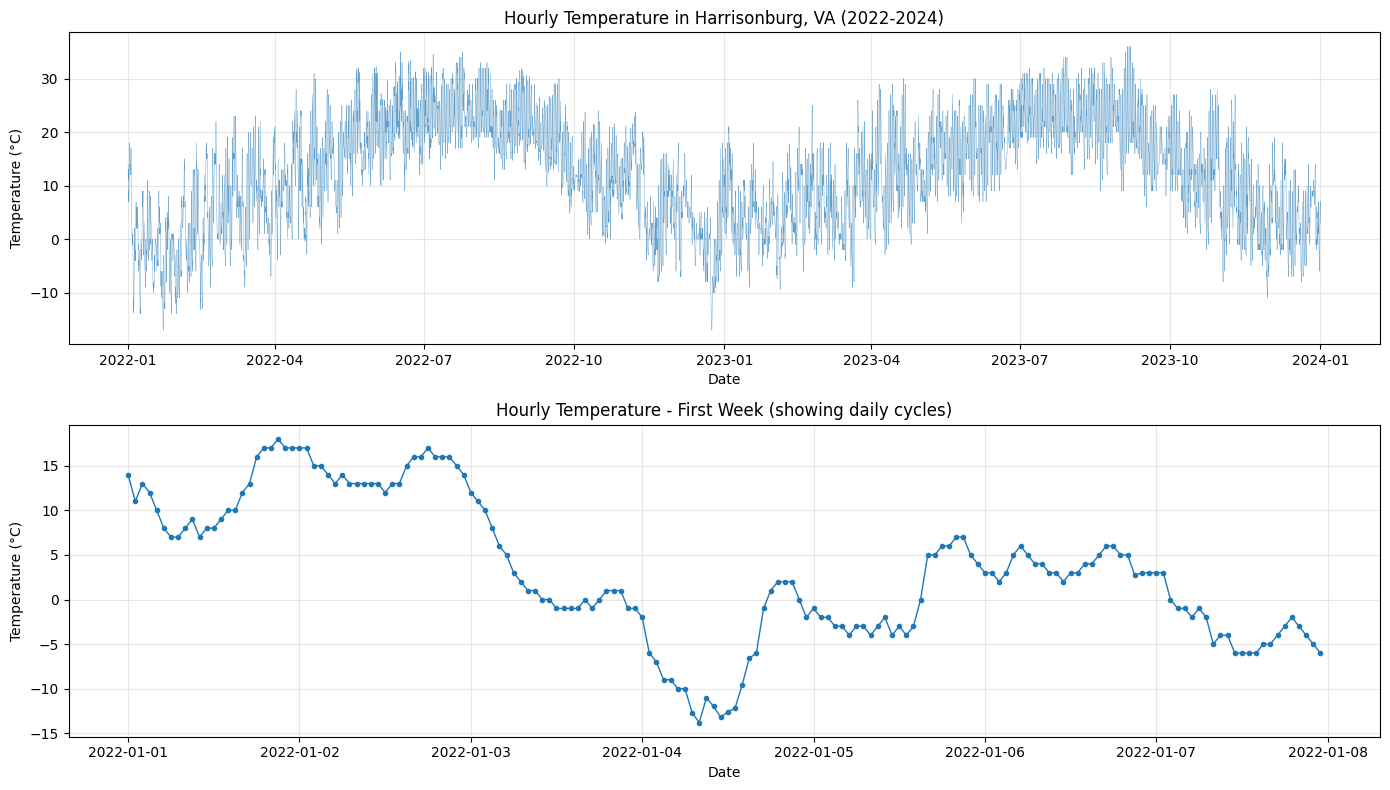

In [2]:
# Prepare weather data (downloads from Meteostat and creates dataloaders)
# Harrisonburg, VA hourly temperatures from 2022-2024, sequence length of 48 hours
data, train_loader, val_loader, temp_mean, temp_std = weather_data.prepare_weather_data(
    latitude=38.4496,     # Harrisonburg, VA
    longitude=-78.8689,
    start_year=2022,
    end_year=2024,
    seq_length=48,         # Predict next hour from previous 48 hours
    batch_size=64
)

# Determine which temperature column is available
temp_col = 'temp'

# Display basic info
print(f"\nFirst few rows:")
print(data.head())

# Plot the temperature over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Full time series
ax1.plot(data.index, data[temp_col], linewidth=0.3, alpha=0.7)
ax1.set_title('Hourly Temperature in Harrisonburg, VA (2022-2024)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)')
ax1.grid(True, alpha=0.3)

# Zoom in on one week to see daily cycles
week_data = data.iloc[:24*7]  # First week
ax2.plot(week_data.index, week_data[temp_col], '.-', linewidth=1)
ax2.set_title('Hourly Temperature - First Week (showing daily cycles)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature (°C)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
def set_device(new_device=None):
    global device
    if new_device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"
    else:
        device=new_device
        
set_device()
print("Using:", device)

Using: cpu


## Exploring Network Structure

The cell below constructs a simple RNN for temperature prediction. This network will predict the next hour's temperature given 48 hours of history.

### Questions
* On a separate sheet of paper, draw the structure of the network created in the cell below.  Every weight in the network should have a corresponding arrow in your diagram.
* Also on a separate sheet of paper, draw the "unrolled" version of this network for three time steps.   
* How many parameters does this network have?

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TemperatureRNN(nn.Module):
    """
    Simple RNN for temperature prediction.
    Predicts the next hour's temperature from a sequence of previous hours.
    """
    
    def __init__(self, hidden_size=2):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        
        # rnn returns: (output, h_n) where
        #   output: hidden states at ALL time steps, shape (batch_size, seq_length, hidden_size)
        #   h_n: hidden state at the FINAL time step, shape (num_layers, batch_size, hidden_size)
        _, h_n = self.rnn(x)  
        
        # We only need the final hidden state for prediction
        # Since we have 1 layer, h_n has shape (1, batch_size, hidden_size)
        # So h_n[-1, :, :] gives us shape (batch_size, hidden_size)
        x = h_n[-1, :, :]

        # Feed the final hidden state through the Linear layer to get prediction
        x = self.out(x)

        return x

model = TemperatureRNN()

print(model)
print("Num parameters: ", count_parameters(model))

TemperatureRNN(
  (rnn): RNN(1, 2, batch_first=True)
  (out): Linear(in_features=2, out_features=1, bias=True)
)
Num parameters:  13


## Training

The cell below contains code for fitting a torch model.  Go ahead and train the model now...

In [5]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the "training" flag to true for the model.
    total_loss = 0

    start_time = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            print(".", end="", flush=True)

    print(f"Epoch time: {time.time() - start_time:.4f}(s)")

    return total_loss / len(dataloader)


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches

    return test_loss


def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    writer = SummaryWriter()
    for t in range(epochs):
        train_one_epoch(train_loader, model, loss_fn, optimizer)
        train_loss = test(train_loader, model, loss_fn)
        val_loss = test(val_loader, model, loss_fn)

        train_str = f"loss: {train_loss:.6f}  "
        val_str = f"validation loss: {val_loss:.6f}"

        writer.add_scalar('Loss/train', train_loss, t)
        writer.add_scalar('Loss/val', val_loss, t)

        print(f"Epoch {t+1} " + train_str + val_str)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

set_device()
model = model.to(device)

train(model, train_loader, val_loader, loss_fn, optimizer, epochs=30)


...Epoch time: 2.7285(s)
Epoch 1 loss: 0.462153  validation loss: 0.487353
...Epoch time: 2.3266(s)
Epoch 2 loss: 0.169396  validation loss: 0.181558
...Epoch time: 2.2239(s)
Epoch 3 loss: 0.108674  validation loss: 0.116708
...Epoch time: 2.2067(s)
Epoch 4 loss: 0.077874  validation loss: 0.083495
...Epoch time: 2.2280(s)
Epoch 5 loss: 0.059746  validation loss: 0.063855
...Epoch time: 2.2111(s)
Epoch 6 loss: 0.048825  validation loss: 0.051801
...Epoch time: 2.2405(s)
Epoch 7 loss: 0.041814  validation loss: 0.044299
...Epoch time: 2.2470(s)
Epoch 8 loss: 0.037226  validation loss: 0.039161
...Epoch time: 2.2419(s)
Epoch 9 loss: 0.034033  validation loss: 0.035777
...Epoch time: 2.2389(s)
Epoch 10 loss: 0.031697  validation loss: 0.033229
...Epoch time: 2.2761(s)
Epoch 11 loss: 0.029844  validation loss: 0.031281
...Epoch time: 2.2052(s)
Epoch 12 loss: 0.028342  validation loss: 0.029634
...Epoch time: 2.2090(s)
Epoch 13 loss: 0.027208  validation loss: 0.028316
...Epoch time: 2.1833

## TensorBoard

The cell below will start up tensorboard and allow you to examine the loss values.  If you train multiple times you can refresh the page using the circular arrow on the upper-right.

In [6]:
%tensorboard --logdir runs

## Examining The Results

The cell below will allow us to visualize the predictions made by our model. First, we predict the next hour's temperature, then we append that prediction to our sequence and use the resulting sequence to predict the hour after that. This way we can make predictions arbitrarily far into the future. 

Unfortunately, our predictions are likely to get farther and farther off as small initial errors compound. You can re-run the cell multiple times to see predictions from different starting points in the validation set.

In [ ]:
# Move the model to CPU for testing
set_device("cpu")
model = model.to(device)

num_predict = 24  # Predict 24 hours into the future
seq_length = 48   # Using 24 hours of history

# Get a random starting point from the validation data
# We'll use actual temperature data as our initial sequence
import random
val_start_idx = random.randint(0, len(data) - seq_length - num_predict - 1)

# Use the same temperature column as determined earlier
temp_col = 'temp'
print(data.columns)

# Extract the initial sequence and ground truth future values
initial_temps = data[temp_col].values[val_start_idx:val_start_idx + seq_length]
future_temps = data[temp_col].values[val_start_idx + seq_length:val_start_idx + seq_length + num_predict]

# Normalize the initial sequence
initial_normalized = (initial_temps - temp_mean) / temp_std
cur_input = torch.Tensor(initial_normalized.reshape(1, seq_length, 1))

# Make predictions autoregressively
predictions = []
indices = []
for i in range(num_predict):
    indices.append(i + seq_length)
    # Predict next hour
    y = model.forward(cur_input)
    # Shift the sequence: remove first hour, append prediction
    cur_input = torch.cat((cur_input[:, 1:, :], y.unsqueeze(1)), axis=1)
    # Denormalize and store prediction
    pred_temp = y.detach().numpy().flatten()[0] * temp_std + temp_mean
    predictions.append(pred_temp)

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(range(seq_length), initial_temps, 'k.-', label='Input (24 hours)', linewidth=2)
plt.plot(indices, future_temps, 'g.-', label='Actual Future', linewidth=2, alpha=0.7)
plt.plot(indices, predictions, 'r.-', label='Predictions', linewidth=2)
plt.axvline(x=seq_length, color='gray', linestyle='--', alpha=0.5, label='Prediction Start')
plt.xlabel('Hour')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Prediction: 24-Hour Forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate error
mae = np.mean(np.abs(np.array(predictions) - future_temps))
print(f"\nMean Absolute Error: {mae:.2f}°C")
print(f"Starting time: {data.index[val_start_idx]}")
print(f"Note: Error accumulates as we predict further into the future!")

## Improving the Model

There are many things we could try that might improve the performance of our temperature prediction model:
* Add more hidden units to our RNN
* Try fancier RNN units like LSTM or GRU (better at capturing long-term patterns)
* Add more RNN layers
* Use more of the weather data as features: relative humidity etc.
* Increase the sequence length (use more hours of history)


### Activity

Experiment with improving performance on the temperature prediction task. How low can you get the validation error? Can you significantly improve the quality of the predictions over multiple time steps?
